In [167]:
import numpy as np
import pandas as pd
import datetime
import plotly.express as px
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords
import markovify
import pickle
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint

In [2]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [3]:
# sort dictionary according to descending frequency of words in recipe and return top N results
def sortedDict(worddict, N):
    newdict = {k: v for k, v in sorted(worddict.items(), key=lambda item: item[1], reverse=True)}
    return dict(list(newdict.items())[:N])

In [111]:
def tokenize(text):
    punctuation_map = str.maketrans('', '', string.punctuation)
    stopwords_list = stopwords.words('english')
    stopwords_list.remove('i')
    stopwords_list.remove('me')
    stopwords_list.append('com')
    stopwords_set = set(stopwords_list)
    text = text.split()
    text = [word for word in text if not ('http' in word or 'www' in word)]
    text = [word.translate(punctuation_map).lower() for word in text]
    tokenized_words = [word for word in text if word not in stopwords_set]
    return tokenized_words

In [24]:
def get_sequence(tokens, length=21):
    sequences = []
    for i in range(length, len(tokens)+1):
        seq = tokens[i-length:i]
        line = ' '.join(seq)
        sequences.append(line)
    return sequences

In [71]:
# generate predictions from model
def generate_sentence(model, tokenizer, sequence_length, starting_text, num_predicted_words):
    prediction = [starting_text]
    for _ in range(num_predicted_words):
        encoded_text = tokenizer.texts_to_sequences([starting_text])[0]
        encoded_text = pad_sequences([encoded_text], 
                                     maxlen=sequence_length, 
                                     truncating='pre')
        preds = model.predict_classes(encoded_text, verbose=0)
        out_word = ''
        for word, idx in tokenizer.word_index.items():
            if idx == preds:
                out_word = word
                break
        starting_text += ' ' + out_word
        prediction.append(out_word)
    return ' '.join(prediction)

In [155]:
data = []
with open('recipeInfo.txt', 'r') as f:
    line = f.readline()
    while line:
        data.append(line[:-2])
        line = f.readline()
f.close()

df_recipe = pd.DataFrame(data, columns=['Recipe'])
df_recipe['Length'] = df_recipe['Recipe'].apply(lambda x: len(x.split()))
df_recipe['Unique Words'] = df_recipe['Recipe'].apply(lambda x: len(set(x.split())))
df_recipe['Tokenized Words'] = df_recipe['Recipe'].apply(tokenize)

In [162]:
df_recipe = pd.read_csv('recipeInfo.csv')
df_recipe = df_recipe.loc[:, ~df_recipe.columns.str.contains('^Unnamed')]
df_recipe['Tokenized Recipe'] = df_recipe['Recipe'].apply(tokenize)
df_recipe['Cleaned Recipe'] = df_recipe['Tokenized Recipe'].str.join(' ')
df_recipe.head(10)

,Recipe,Length,Unique Words,Tokenized Recipe,Cleaned Recipe
0,I was intrigued with this recipe from foolishp...,364,231,"[i, intrigued, recipe, foolishpoolish, also, p...",i intrigued recipe foolishpoolish also poking ...
1,"Here is the link to my recipe, as requested by...",345,206,"[link, recipe, requested, bread1965, starter, ...",link recipe requested bread1965 starter refres...
2,My first bake of 2018. I'm glad I squeezed in ...,889,415,"[first, bake, 2018, im, glad, i, squeezed, bak...",first bake 2018 im glad i squeezed bake despit...
3,Oh my....that's about all I can say. The blue ...,297,189,"[oh, mythats, i, say, blue, granite, roaster, ...",oh mythats i say blue granite roaster definite...
4,Love this bread but I have a few questions for...,80,57,"[love, bread, i, questions, anyone, regularly,...",love bread i questions anyone regularly bakes ...
5,how often can a person make and eat pizza befo...,202,133,"[often, person, make, eat, pizza, get, tired, ...",often person make eat pizza get tired apparen...
6,A fabulous and incredibly informative set of e...,164,128,"[fabulous, incredibly, informative, set, email...",fabulous incredibly informative set email exch...
7,It looks and smells grand and I will get to cu...,33,28,"[looks, smells, grand, i, get, cut, open, peek...",looks smells grand i get cut open peek crumb l...
8,the banana rye date and pecan bread made it to...,30,29,"[banana, rye, date, pecan, bread, made, iron, ...",banana rye date pecan bread made iron skillet ...
9,The dough is the Tartine Basic Country Bread. ...,126,92,"[dough, tartine, basic, country, bread, formul...",dough tartine basic country bread formula pole...


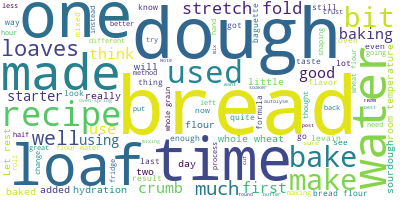

In [158]:
# import the wordcloud library
from wordcloud import WordCloud
# join the different processed titles together.
long_string = ','.join(list(df_recipe['Recipe'].values))
# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# generate a word cloud
wordcloud.generate(long_string)
# visualize the word cloud
wordcloud.to_image()

In [90]:
# generate a histogram with word frequency counts, but without stop words

recipe_split = [string.split(' ') for string in df_recipe['Recipe'].tolist()]
word_list = [word.translate(str.maketrans('', '', string.punctuation)).lower() 
             for recipe in recipe_split for word in recipe]
word_list = [word for word in word_list if word not in set(stopwords.words('english'))]
word_dict = sortedDict( wordListToFreqDict(word_list), 21 )

In [97]:
df = pd.DataFrame(list(word_dict.items())[1:], columns=['Word', 'Frequency'])
fig = px.bar(df, x=df['Word'], y=df['Frequency'], orientation='v')
fig.show()

In [173]:
# performing LDA for topic modeling

count_vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
count_data = count_vectorizer.fit_transform(df_recipe['Cleaned Recipe'])

number_topics = 5
number_words = 15

lda = LDA(n_components=number_topics, n_jobs=-1, learning_method='batch', max_iter=50, random_state=42)
lda.fit(count_data)

# function to print n top words from each topics found by the LDA fit
def print_topics_LDA(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# print the topics found by the LDA model
print("Topics found via LDA:")
print_topics_LDA(lda, count_vectorizer, number_words)

# assign topic to each recipe entry in dataframe
topic_values = lda.transform(count_data)
df_recipe['Topic'] = topic_values.argmax(axis=1)

Topics found via LDA:

Topic #0:
flour dough water levain hydration bread crumb time loaf salt hours rye bake loaves wheat

Topic #1:
dough minutes let flour hours water oven mix temperature bowl bake place add rest bread

Topic #2:
bread loaf flour baking recipe sourdough time im good make yeast dough oven like ive

Topic #3:
water thermal heat baking energy process temperature density things like know cake specific moisture bakers

Topic #4:
bread like time butter make dough pizza cheese sugar breads baking flavor sourdough used day


In [ ]:
# visualize topics using pyLDAvis package
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, mds='tsne')
panel

In [174]:
# performing NMF for topic modeling

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vectorizer.fit_transform(df_recipe['Cleaned Recipe'])

nmf = NMF(n_components=number_topics, random_state=42)
nmf.fit(doc_term_matrix)

# function to print n top words from each topics found by the NMF fit
def print_topics_NMF(model, tfidf_vectorizer, n_top_words):
    words = tfidf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("Topics found via NMF:")
print_topics_NMF(nmf, tfidf_vectorizer, number_words)

Topics found via NMF:

Topic #0:
bread sourdough recipe like time im baking dough loaf think ive good make crumb breads

Topic #1:
let dough hours minutes temperature pan bowl degrees sit refrigerator remove place oven steam covered

Topic #2:
berries flour levain rye 50 day recipe seeds water extraction loaves kamut unbleached wheat spelt

Topic #3:
flour pm water minutes min hours dough starter salt loaf hydration bulk folds 30 10

Topic #4:
dough minutes place counter let flour seam rounds speed mix cover add pull water middle


In [25]:
recipes_token = df_recipe['Tokenized Recipe'].tolist()
token_sequences = [token for recipe in recipes_token for token in get_sequence(recipe)]

In [26]:
file = open('tokenized_recipes.txt', 'w')
file.write('\n'.join(token_sequences))
file.close()

In [176]:
# build Markov Chain model using markovify to predict text

recipes = df_recipe['Cleaned Recipe'].tolist()
text_model = markovify.NewlineText(recipes, state_size=2)
for idx in range(2):
    print(idx, text_model.make_sentence())

0 hello friends weeks bake impact oat bran spelt bran sifted previously levain really makes wonderful difference breads texture see incredible oven spring i wonder anyone good recipe would 300g h2o 450g flour subtract poolish get water flour triple noon i peachy honey alcohol smelling starter hands sorry pics i followed hotbakes lovely recipe stanley ginsburg site theryebakercom stage 1 sponge day one morning i bake i left oven self cleaning process looks like much shorter gentle rubaud adding levain addins 90 g durum berries 50 g honey 260 g sort preshape rested 10 minutes bake time 4550 minutes internal temperatures rise stuff starch gelatinization protein coagulation impede 7 simple description temperature alters thermal conductivity considered optimal activity reason precautions generally taken avoid deflation ball little bit canola oil bulk container 83 hydration i dont want bread one favorites cream cheese rollin form sourdough bread modernist bread i managed barely stuff roastin

In [191]:
def getSent(model, iters, minLength=1):
  sentences = {}
  for i in range(iters): 
    modelGen = model.chain.gen()
    prevPrevWord = "___BEGIN__"
    prevWord = next(modelGen)
    madeSentence = prevWord + " "
    
    totalScore = 0
    numWords = 1
    for curWord in modelGen:
      madeSentence += curWord + " "
      numWords += 1
      totalScore += model.chain.model[(prevPrevWord, prevWord)][curWord]
      prevPrevWord = prevWord
      prevWord = curWord
    
    madeSentence = madeSentence.strip()
    if numWords == 0: continue
    
    if numWords < minLength: continue
    if madeSentence in sentences: continue
    
    totalScore += model.chain.model[(prevPrevWord, prevWord)]["___END__"]
    
    sentences[madeSentence] = totalScore/float(numWords)
  
  # Get the sentences as (sentence, score) pairs and sort them so the sentences with the highest score appear first
  sorted(sentences.items(), key=lambda x: -x[1])
  
  return sentences.items()

list(getSent(text_model, 500, 4))[0]

('i decided venture away thatsort i first started baking encouraged wife try something new i’m retired us army infantry officer 10 years based average yearly returns top 25 returned 05 past 44 years wow entire time bakingjim recommends slice dough top brown dough shape desired place dough proofing baskets cover moist tea towel plastic wrap let sit linen tea towel plastic wrap let sit room temperature seems like ought heavier water it’s prevalent earthly material always expressed weight per unit volume words i thimble coffee cup boot space old mgb obviously require different weights substance fill unit measure changes weight required fill us standard handbag per big old box i gradually increase temperature takes energy input thermal energy takes energy heat specific heat capacity metal obvious since know aluminum pot i still havent chance try tonight',
 4.897058823529412)

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_sequences)
num_sequences = tokenizer.texts_to_sequences(token_sequences)
num_sequences = pad_sequences(num_sequences, padding='pre')
vocab_size = len(tokenizer.word_index) + 1

In [28]:
sequences_array = np.array(num_sequences)
X, y = sequences_array[:,:-1], sequences_array[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [29]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# train_text = []
# for idx in range(len(X)):    
#     strings = [str(x) for x in X[idx].tolist()]
#     train_text.append(','.join(strings))

In [ ]:
# train_data = pd.DataFrame(train_text)
# train_data.to_csv('train_data.csv')

In [ ]:
# training_labels = pd.DataFrame(sequences_array[:,-1])
# training_labels.head()
# training_labels.to_csv('train_labels.csv')

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, seq_length, input_length=seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 20)            338700    
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 50)            14200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 16935)             863685    
Total params: 1,239,335
Trainable params: 1,239,335
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
path = './checkpoints/recipe_model.h5'
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='min')
model.fit(X, y, batch_size=128, epochs=140, verbose=1, callbacks=[checkpoint])
pickle.dump(tokenizer, open('tokenizer_model.pkl','wb'))
model.save('trained_recipe_model.h5')

Epoch 1/100
196659/196659 [==============================] - 172s 875us/step - loss: 7.1892 - accuracy: 0.0499

Epoch 00001: loss improved from inf to 7.18920, saving model to ./checkpoints/recipe_model.h5
Epoch 2/100
196659/196659 [==============================] - 175s 889us/step - loss: 6.9302 - accuracy: 0.0647

Epoch 00002: loss improved from 7.18920 to 6.93024, saving model to ./checkpoints/recipe_model.h5
Epoch 3/100
196659/196659 [==============================] - ETA: 0s - loss: 6.6744 - accuracy: 0.07 - 179s 912us/step - loss: 6.6743 - accuracy: 0.0771

Epoch 00003: loss improved from 6.93024 to 6.67426, saving model to ./checkpoints/recipe_model.h5
Epoch 4/100
196659/196659 [==============================] - 171s 871us/step - loss: 6.4439 - accuracy: 0.0918

Epoch 00004: loss improved from 6.67426 to 6.44389, saving model to ./checkpoints/recipe_model.h5
Epoch 5/100
196659/196659 [==============================] - 171s 871us/step - loss: 6.2292 - accuracy: 0.1097

Epoch 0000

Epoch 40/100
196659/196659 [==============================] - 171s 871us/step - loss: 3.9231 - accuracy: 0.2941

Epoch 00040: loss improved from 3.94937 to 3.92312, saving model to ./checkpoints/recipe_model.h5
Epoch 41/100
196659/196659 [==============================] - 172s 876us/step - loss: 3.9034 - accuracy: 0.2968

Epoch 00041: loss improved from 3.92312 to 3.90340, saving model to ./checkpoints/recipe_model.h5
Epoch 42/100
196659/196659 [==============================] - 173s 880us/step - loss: 3.8774 - accuracy: 0.2995

Epoch 00042: loss improved from 3.90340 to 3.87740, saving model to ./checkpoints/recipe_model.h5
Epoch 43/100
196659/196659 [==============================] - 171s 871us/step - loss: 3.8567 - accuracy: 0.3017

Epoch 00043: loss improved from 3.87740 to 3.85669, saving model to ./checkpoints/recipe_model.h5
Epoch 44/100
196659/196659 [==============================] - 170s 866us/step - loss: 3.8304 - accuracy: 0.3052

Epoch 00044: loss improved from 3.85669 to 

Epoch 79/100
196659/196659 [==============================] - 168s 855us/step - loss: 3.3241 - accuracy: 0.3705

Epoch 00079: loss improved from 3.33657 to 3.32413, saving model to ./checkpoints/recipe_model.h5
Epoch 80/100
196659/196659 [==============================] - 168s 856us/step - loss: 3.3169 - accuracy: 0.3702

Epoch 00080: loss improved from 3.32413 to 3.31693, saving model to ./checkpoints/recipe_model.h5
Epoch 81/100
196659/196659 [==============================] - 168s 856us/step - loss: 3.3019 - accuracy: 0.3728

Epoch 00081: loss improved from 3.31693 to 3.30185, saving model to ./checkpoints/recipe_model.h5
Epoch 82/100
196659/196659 [==============================] - 168s 853us/step - loss: 3.2997 - accuracy: 0.3735

Epoch 00082: loss improved from 3.30185 to 3.29971, saving model to ./checkpoints/recipe_model.h5
Epoch 83/100
196659/196659 [==============================] - 170s 863us/step - loss: 3.2859 - accuracy: 0.3756

Epoch 00083: loss improved from 3.29971 to 

NameError: name 'dump' is not defined

In [69]:
new_model = load_model('./checkpoints/epoch100_recipe_model.h5')
new_model.fit(X, y, batch_size=128, epochs=40, verbose=1, callbacks=[checkpoint])
new_model.save('epoch140_trained_recipe_model.h5')

/Users/pratimasatish/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/40
196659/196659 [==============================] - 182s 928us/step - loss: 3.1422 - accuracy: 0.3950

Epoch 00001: loss improved from 3.14888 to 3.14224, saving model to ./checkpoints/recipe_model.h5
Epoch 2/40
196659/196659 [==============================] - 192s 979us/step - loss: 3.1336 - accuracy: 0.3970

Epoch 00002: loss improved from 3.14224 to 3.13361, saving model to ./checkpoints/recipe_model.h5
Epoch 3/40
196659/196659 [==============================] - 175s 892us/step - loss: 3.1229 - accuracy: 0.3979

Epoch 00003: loss improved from 3.13361 to 3.12287, saving model to ./checkpoints/recipe_model.h5
Epoch 4/40
196659/196659 [==============================] - 183s 930us/step - loss: 3.1239 - accuracy: 0.3981

Epoch 00004: loss did not improve from 3.12287
Epoch 5/40
196659/196659 [==============================] - 204s 1ms/step - loss: 3.1105 - accuracy: 0.4005

Epoch 00005: loss improved from 3.12287 to 3.11052, saving model to ./checkpoints/recipe_model.h5
Epoch 6/

In [186]:
generate_sentence(model, tokenizer, seq_length, 'i made bread', 50)

'i made bread cloves 1 g water 384 g water 735 g high extraction spelt flour 200 g red fife berries 50 g freshly ground flax seeds 725 g water 22 g pink himalayan salt 30 g yogurt 20 g salt 250 g levain procedure recipe extra wholegrain flour feeding autolyze 88 g'

In [ ]:
# group recipes by yeast, levain and others